In [321]:
import numpy as np

import sympy as sp
from sympy import Symbol, symbols, solve, Eq, E

from sympy.matrices import Matrix, eye, BlockMatrix, zeros, block_collapse, diag
from sympy.plotting import plot, plot_implicit
from sympy.plotting.plot import List2DSeries

from sympy.physics.quantum import TensorProduct

from scipy.stats import norm

import matplotlib.pyplot as plt

$Y_t$ = $\big[ GNP_t, M2_t, IR_t \big]^T$

$Y_t = \nu + A_1 Y_{t-1} + A_2 Y_{t-2} + u_t$

$u_t \sim N(0, \Sigma_u),   \Sigma_u = PP'$

In [158]:
nu = Matrix([2, 1, 0])

A1 = Matrix([[.7, .1, 0],
             [0, .4, .1],
             [.9, 0, .8]])

A2 = Matrix([[-.2, 0, 0],
             [0, .1, .1],
             [0, 0, 0]])

P = Matrix([[.5, .1, 0],
            [0, .3, 0],
            [0, 0, .9]])

In [244]:
Sigma = P * P.T

## 1) Show that process $Y_t$ is stable

In [59]:
z = Symbol('z')

In [60]:
stab = eye(3) - A1 * z - A2 * z**2
stab

Matrix([
[0.2*z**2 - 0.7*z + 1,                -0.1*z,                 0],
[                   0, -0.1*z**2 - 0.4*z + 1, -0.1*z**2 - 0.1*z],
[              -0.9*z,                     0,         1 - 0.8*z]])

In [61]:
stab.det()
roots = solve(stab.det())
roots

[-5.58083612351941,
 1.09901515470491,
 2.89366752825762,
 1.45032672027844 - 1.19082258398344*I,
 1.45032672027844 + 1.19082258398344*I]

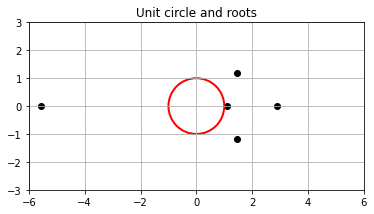

In [156]:
circle = plt.Circle((0, 0), 1, color='r', linewidth=2, fill=False)

fig, ax = plt.subplots()
plt.xlim(-6, 6)
plt.ylim(-3,3)
plt.grid()
plt.title('Unit circle and roots')

ax.set_aspect(1)

ax.add_artist(circle)

for r in roots:
    ax.scatter(*r.as_real_imag(), color='black')

## 2) Determine the mean vector of $y_t$.

In [160]:
mu = (eye(3) - A1 - A2).inv() * nu

mu

Matrix([
[  6.875],
[ 14.375],
[30.9375]])

## 3) Write $y_t$ in VAR(1) form

$Y_t = \nu + A X_t + U_t $

In [204]:
A = Matrix(BlockMatrix([[A1, A2], [eye(3), zeros(3)]]))
A

Matrix([
[0.7, 0.1,   0, -0.2,   0,   0],
[  0, 0.4, 0.1,    0, 0.1, 0.1],
[0.9,   0, 0.8,    0,   0,   0],
[  1,   0,   0,    0,   0,   0],
[  0,   1,   0,    0,   0,   0],
[  0,   0,   1,    0,   0,   0]])

In [205]:
NU = Matrix(BlockMatrix([[nu], [zeros(3,1)]]))

NU

Matrix([
[2],
[1],
[0],
[0],
[0],
[0]])

## 4) Compute first five matrices $\Phi_i$ of the MA representation for the process.

In [206]:
J = Matrix(BlockMatrix([[eye(3), zeros(3)]]))

J

Matrix([
[1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0]])

In [217]:
фi = []

for i in range(1,6):
    ф = J * A**i * J.T
    фi.append(ф)

In [223]:
Ф1, Ф2, Ф3, Ф4, Ф5 = фi

In [224]:
Ф1

Matrix([
[0.7, 0.1,   0],
[  0, 0.4, 0.1],
[0.9,   0, 0.8]])

## 5) Determine the autocovariances $\Gamma_y(0) - \Gamma_y(3)$.

In [273]:
SigmaU = Matrix(BlockMatrix([[Sigma, zeros(3)], [zeros(3), zeros(3)]]))

first =  (eye( (3*2)**2 ) - TensorProduct(A, A)).inv()
second = SigmaU.vec()

vecГY0 = first * second
ГY0 = vecГY0.reshape(6,6)

In [266]:
Гy0 = ГY0[0:3,0:3]
Гy0

Matrix([
[0.447181655548895, 0.191394821784428, 0.556959329546081],
[0.191394821784427, 0.843734428950632,  1.64527595980267],
[0.556959329546082,  1.64527595980267,  5.48399604316934]])

In [272]:
Гy1 = ГY0[0:3,3:6]
Гy1

Matrix([
[0.276805534218891, 0.180591359893882, 0.38479293593635],
[0.188792291251402, 0.762713033077856, 1.84420362209551],
[0.848030953630872,  1.48847610744812, 4.88846023112695]])

In [304]:
Гy2 = A1 * Гy1 + A2 * Гy0
Гy3 = A1 * Гy2 + A2 * Гy1

## 6) Determine the autocorrelations $R_y(0) - R_y(3)$.

In [328]:
f = lambda x: x ** 0.5

d = Гy0.diagonal()
d = d.applyfunc(f)

D = Matrix.diag(*d)

In [329]:
Ry0 = D.inv() * Гy0 * D.inv()
Ry0

Matrix([
[              1.0, 0.311591289451092, 0.355658282599936],
[0.311591289451091,               1.0, 0.764869423889553],
[0.355658282599936, 0.764869423889553,               1.0]])

In [330]:
Ry1 = D.inv() * Гy1 * D.inv()
Ry2 = D.inv() * Гy2 * D.inv()
Ry3 = D.inv() * Гy3 * D.inv()

## 7) Suppose that $y_{2000}$ = $\big[0.7, \ 1.0, \ 1.5\big]^T $ and $y_{1999}$ = $\big[1.0, \ 1.5, \ 3.0\big]^T $. Forecast $y_{2001}, y_{2002}, y_{2003}$

In [311]:
y2000 = Matrix([.7, 1., 1.5])
y1999 = Matrix([1., 1.5, 3.])

In [313]:
y2001 = nu + A1 * y2000 + A2 * y1999
y2001

Matrix([
[2.39],
[ 2.0],
[1.83]])

In [316]:
y2002 = nu + A1 * y2001 + A2 * y2000
y2003 = nu + A1 * y2002 + A2 * y2001

## 8) Compute the MSE matrices for the forecast horizons $h = 1, 2, 3$

In [317]:
MSE1 = Sigma
MSE1

Matrix([
[0.26, 0.03,    0],
[0.03, 0.09,    0],
[   0,    0, 0.81]])

In [353]:
MSE2 = MSE1 + Ф1 * Sigma * Ф1.T
MSE3 = MSE2 + Ф2 * Sigma * Ф2.T

## 9) Assuming that $y_t$ is Gaussian, construct $95\%$ confidence intervals for $t=2001, 2002, 2003$.

In [325]:
alpha = 0.95
z95 = norm.ppf(1 - (1 - alpha)/2)

In [338]:
err2001 = MSE1.diagonal().reshape(3,1).applyfunc(lambda x: x**0.5) * z95
err2001

Matrix([
[ 0.99938946031088],
[0.587989195362016],
[ 1.76396758608605]])

In [341]:
cf2001 = (y2001-err2001, y2001+err2001)

In [342]:
err2002 = MSE2.diagonal().reshape(3,1).applyfunc(lambda x: x**0.5) * z95
err2003 = MSE3.diagonal().reshape(3,1).applyfunc(lambda x: x**0.5) * z95

cf2002 = (y2002-err2002, y2002+err2002)
cf2003 = (y2003-err2003, y2003+err2003)

## 10) Using Bonferroni method, determine a joint forecast region for $GNP_{2001}, GNP_{2002}, GNP_{2003}$ with probability content at least $97\%$.

In [401]:
alpha = 0.99
z99 = norm.ppf(1 - (1-alpha)/2 )

In [349]:
GNP2001 = y2001[0]
GNP2002 = y2002[0]
GNP2003 = y2003[0]

In [351]:
GNPerr2001 = MSE1[0,0] ** 0.5 * z99
GNPerr2002 = MSE2[0,0] ** 0.5 * z99
GNPerr2003 = MSE3[0,0] ** 0.5 * z99

In [352]:
jointGNP = Matrix([[GNP2001 - GNPerr2001, GNP2001 + GNPerr2001],
                  [GNP2002 - GNPerr2002, GNP2002 + GNPerr2002],
                  [GNP2003 - GNPerr2003, GNP2003 + GNPerr2003]])

jointGNP

Matrix([
[  1.076579611752,   3.703420388248],
[2.11924756672505, 5.34675243327495],
[2.69414713877479, 6.02265286122521]])

## 11) Check the following causality relationships:

* M2 is Granger causal for (GNP, IR)
* IR is Granger causal for (GNP, M2)
* M2 is instanteous causal for (GNP, IR)
* IR is instanteous causal for (GNP, M2)


In [397]:
#GNP, M2, IR -> M2, GNP, IR
#If any is nonzero, than causal

permA1 = A1.elementary_col_op("n<->m", 1,0).elementary_row_op("n<->m", 1, 0)
permA1[0,1:3]

Matrix([[0, 0.1]])

In [398]:
#GNP, M2, IR -> IR, GNP, M2
permA1 = A1.elementary_col_op("n<->m", 2,0).elementary_row_op("n<->m", 2, 0)
permA1[0,1:3]

Matrix([[0, 0.9]])

In [399]:
#GNP, M2, IR -> M2, GNP, IR
permS = Sigma.elementary_col_op("n<->m", 1,0).elementary_row_op("n<->m", 1, 0)
permS[0,1:3]

Matrix([[0.03, 0]])

In [400]:
#GNP, M2, IR -> IR, GNP, M2
permS = Sigma.elementary_col_op("n<->m", 2,0).elementary_row_op("n<->m", 2, 0)
permS[0,1:3]

Matrix([[0, 0]])

## 12) Plot the effect of unit innovation in IR on the three variables in term of MA representation for 5 periods.

In [419]:
irIR1 = (J * A * J.T)[:,2]
irIR2 = (J * A**2 * J.T)[:,2]
irIR3 = (J * A**3 * J.T)[:,2]
irIR4 = (J * A**4 * J.T)[:,2]
irIR5 = (J * A**5 * J.T)[:,2]

In [420]:
irIR = Matrix([[irIR1, irIR2, irIR3, irIR4, irIR5]])

irIR

Matrix([
[  0, 0.01, 0.029, 0.0425, 0.04744],
[0.1, 0.22, 0.242, 0.2349, 0.21455],
[0.8, 0.64, 0.521, 0.4429, 0.39257]])

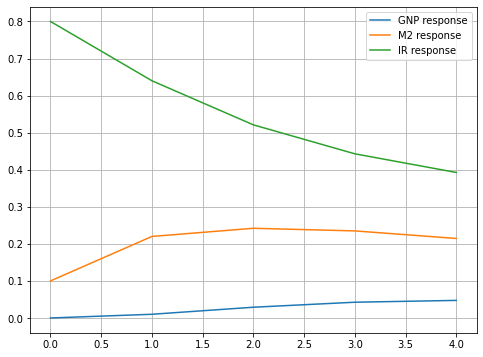

In [434]:
irIR_np = np.array(irIR)

plt.figure(figsize=(8,6))
plt.plot(irIR_np[0], label='GNP response')
plt.plot(irIR_np[1], label='M2 response')
plt.plot(irIR_np[2], label='IR response')
plt.grid()
plt.legend()
plt.show()